### Find matches of projected points

In [1]:
import pickle
import glob
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

In [2]:
camera_matrix = pickle.load(open("camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("data_association/pose_graph_.pkl", "rb"))
map_points = pickle.load(open("data_association/map_points_.pkl", "rb"))

In [3]:
def from_twist(twist):
    """Convert a 6D twist coordinate (shape (6,)) into a 3x3 rotation matrix
    and translation vector (shape (3,))."""
    r = twist[:3].reshape(3, 1)
    t = twist[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(r)
    return R, t

In [4]:
def get_visible_points_mask(pts, frame_width, frame_height):
    """Remove points from pts which fall outside the frame."""
    min_bb = np.array([0, 0])
    max_bb = np.array([frame_width, frame_height])
    mask = np.all(np.logical_and(
        min_bb <= pts.reshape(-1, 2), pts.reshape(-1, 2) <= max_bb), axis=1)
    return mask

In [5]:
def get_representative_orb(descriptors):
    """Returns a representative ORB descriptor in a list of descriptors.
    
    Args:
        descriptors (`list` of `numpy.ndarray`): Each list item is an ORB
            descriptor of dtype uint8 and shape (32,).
    
    Returns:
        representative_orb (`numpy.ndarray`): The representative ORB descriptor 
        which is the one with smallest Hamming distance to all other descriptors 
        in the provided list.
    """
    descriptors = np.vstack(descriptors)
    #print(descriptors.shape)
    dist = pdist(descriptors, metric="hamming")
    dist = squareform(dist)
    #print(dist)
    #print(np.sum(dist, axis=0))
    rep_idx = np.argmin(np.sum(dist, axis=0))
    #print(rep_idx)
    representative_orb = descriptors[rep_idx, :]
    return representative_orb

0
mask sum: 3422
Found 457 new matches


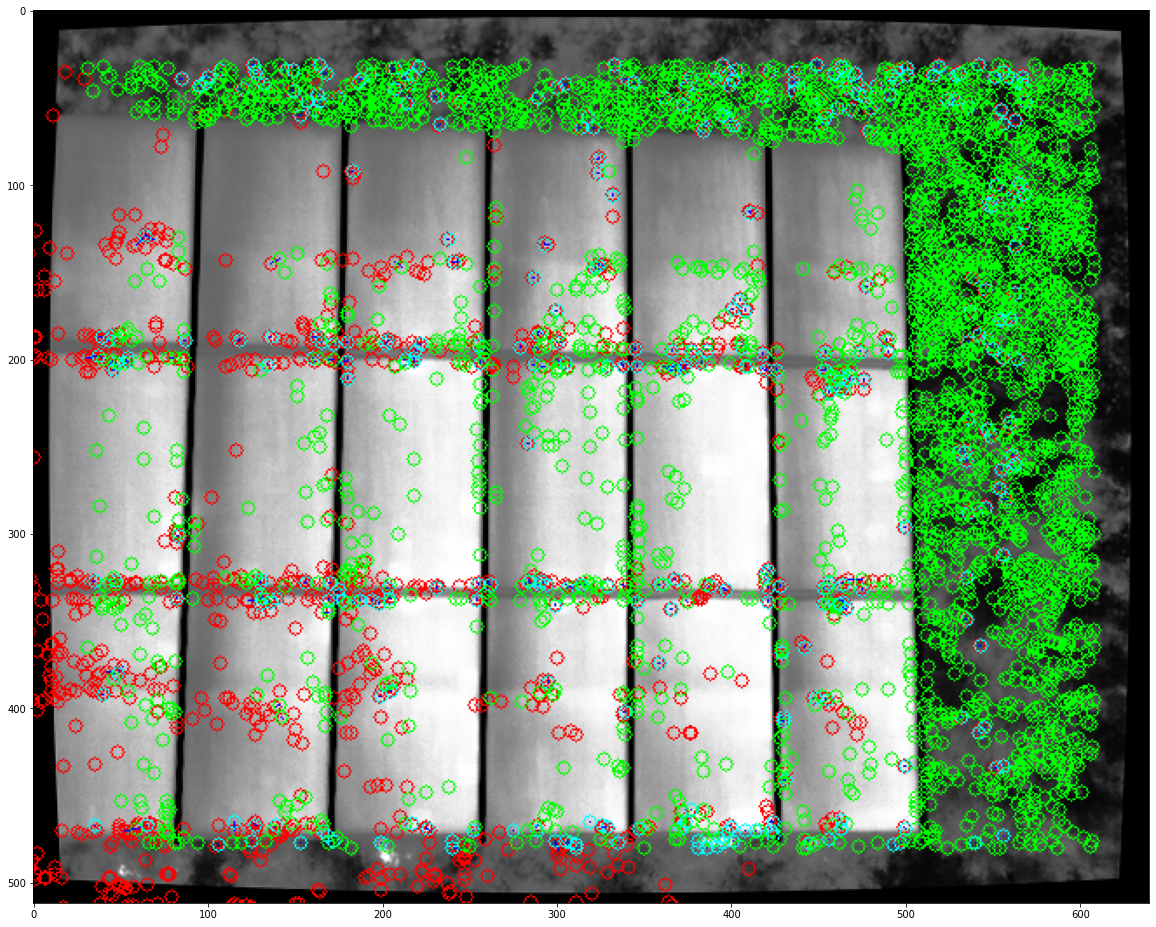

1
mask sum: 5344
Found 794 new matches


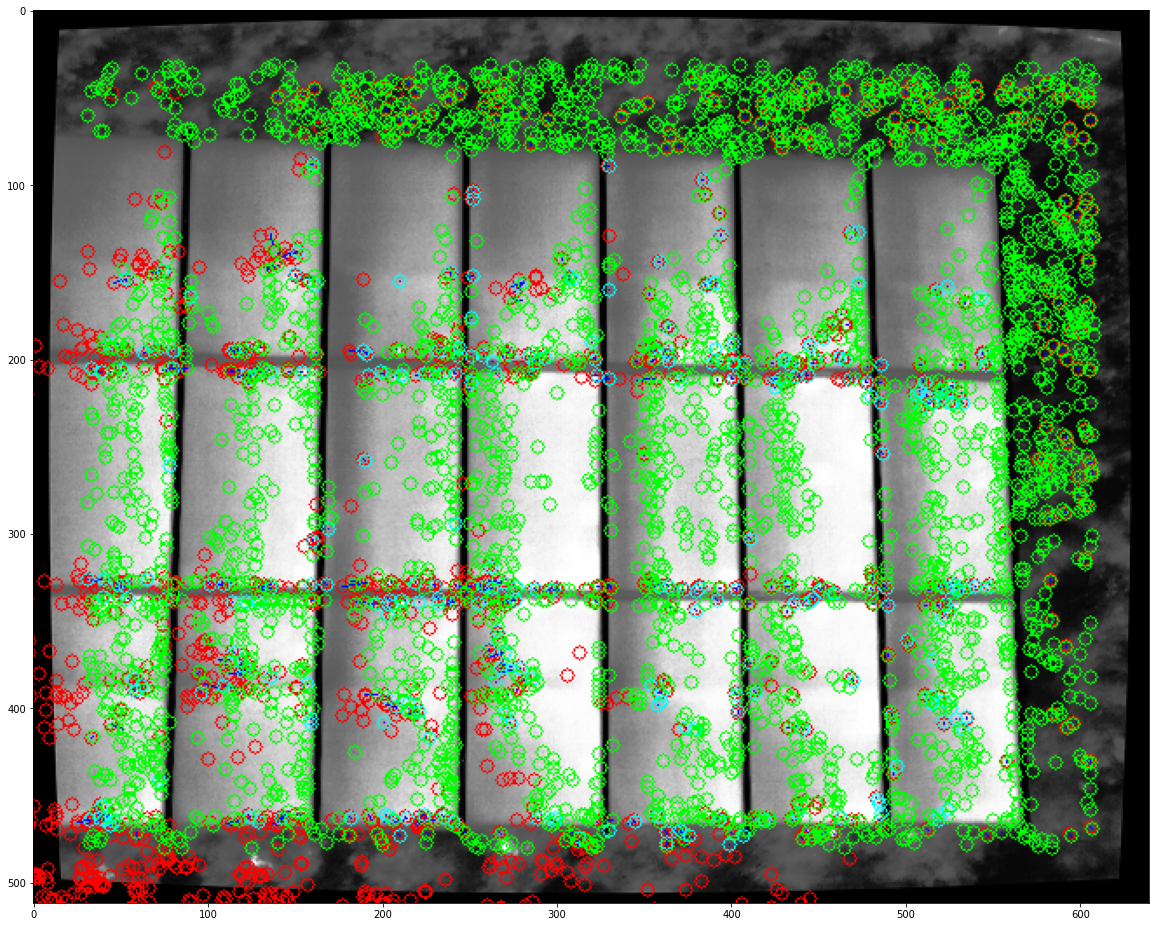

2


In [ ]:
descriptors = defaultdict(list)

for node_id in sorted(pose_graph.nodes):
    print(node_id)
    frame = pose_graph.nodes[node_id]["frame"]
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                         
    projected_pts = pickle.load(open("data_association/projected_pts_{}.pkl".format(node_id), "rb"))
    for pts in projected_pts:
        frame = cv2.circle(frame, (int(pts[0, 0]), int(pts[0, 1])), 4, (0, 0, 255))
    
    # for each projected point visible in KF[node_id]
    # search for matches with keypoints in local neighborhod of projected point
    # if match could be found update the visible KF and associated kp indices of the corresponding map point
    kp = cv2.KeyPoint_convert(pose_graph.nodes[node_id]["kp"].reshape(-1, 1, 2))
    des = pose_graph.nodes[node_id]["des"]
    kp_matched = np.array(pose_graph.nodes[node_id]["kp_matched"])    
 
    # mask out keypoints which were already matched
    # queryDescriptors[i] can be matched with trainDescriptors[j] only if mask[i,j] is non-zero
    #mask = np.ones(())
    
    # build a mask for ORB descriptor matching which permits only matches of nearby points
    max_distance = 8.0  # px
    mask = np.zeros((len(map_points.representative_orb), len(des)), dtype=np.uint8)
    kdtree = KDTree(cv2.KeyPoint_convert(kp).astype(np.uint16))  # KD-tree for fast lookup of neighbors
    neighbor_kp_idxs = kdtree.query_ball_point(projected_pts.reshape(-1, 2), r=max_distance)
    for map_point_idx, kp_idxs in enumerate(neighbor_kp_idxs):
        for kp_idx in kp_idxs:    
            mask[map_point_idx, kp_idx] = 1
    print("mask sum:", np.sum(mask))
    #break
    
    
    # find matches between projected map points and descriptors
    distance_threshold = 20.0
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)  # set to False
    matches = bf.match(map_points.representative_orb, des, mask)
    #matches = sorted(matches, key = lambda x:x.distance)
    # filter out matches with distance (descriptor appearance) greater than threshold
    matches = [m for m in matches if m.distance < distance_threshold]
    print("Found {} new matches".format(len(matches)))
    
    for match in matches:
        map_point_idx = match.queryIdx
        kp_idx = match.trainIdx        
        pt1 = (int(projected_pts[map_point_idx, 0, 0]), int(projected_pts[map_point_idx, 0, 1]))
        pt2 = (int(kp[kp_idx].pt[0]), int(kp[kp_idx].pt[1]))
        frame = cv2.line(frame, pt1, pt2, (255,0,0), 1)
    
    # get only those projected map points visible in the current key frame
    visible = get_visible_points_mask(projected_pts, frame_width=frame.shape[1], frame_height=frame.shape[0])
    
    # matches meaning:
    # m.queryIdx: index of projected map point
    # m.trainIdx: index of keypoint in current KF

    for match in matches:
        map_point_idx = match.queryIdx
        kp_idx = match.trainIdx
        
        if not visible[map_point_idx]:
            #print("map point ", map_point_idx, " not visible")
            continue
            
        descriptors[map_point_idx].append(des[kp_idx])
        
        if node_id in map_points.observing_keyframes[map_point_idx]:  # should not be the case anyway 
            continue
            
        # update observing keyframes
        map_points.observing_keyframes[map_point_idx].append(node_id)

        # update associated keypoint indices of the matched map points
        map_points.associated_kp_indices[map_point_idx].append(kp_idx)
        #print("kp_idx", kp_idx)
        #print(map_points.observing_keyframes[map_point_idx])
        #print(map_points.associated_kp_indices[map_point_idx])
    
    for p, matched in zip(kp, kp_matched):
        if matched:
            color = (255, 255, 0)
        else:
            color = (0, 255, 0)
        frame = cv2.circle(frame, (int(p.pt[0]), int(p.pt[1])), 4, color)

    # colors
    # red : projected map points
    # cyan : current kps alreay matched
    # green : current kps unmatched
    fig = plt.figure()
    fig.set_size_inches(20,20)
    plt.imshow(frame[:, :, ::-1])
    plt.show()

# update representative ORB descriptors of map points
for map_point_idx, des in descriptors.items():
    if len(des) < 2:
        continue
    map_points.representative_orb[map_point_idx, :] = get_representative_orb(des)

In [ ]:
Counter([len(k) for k in map_points.associated_kp_indices])

In [ ]:
Counter([len(k) for k in map_points.observing_keyframes])

In [ ]:
np.where([len(k) == 5 for k in map_points.observing_keyframes])

In [ ]:
# check if result makes sense

In [ ]:
map_point_idx = 1926  # all point sunder 514 work well

observing_keyframes = map_points.observing_keyframes[map_point_idx]
print("Observing keyframes:", observing_keyframes)

for node_id in sorted(pose_graph.nodes):
    if node_id not in observing_keyframes:
        continue
    #print(node_id)
    
    frame = pose_graph.nodes[node_id]["frame"]
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    # project map point into frame
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    t = -R.T.dot(t)
    R = R.T
    projected_pts, _ = cv2.projectPoints(map_points.pts_3d[map_point_idx, :], R, t, camera_matrix, None)
    print("projected_pts", int(projected_pts[0, 0, 0]), int(projected_pts[0, 0, 1]))
    frame = cv2.circle(frame, (int(projected_pts[0, 0, 0]), int(projected_pts[0, 0, 1])), 2, (255, 255, 0))
    
    
    # get keypoint associated to the selected map point
    #print(map_points.associated_kp_indices[map_point_idx])
    i = observing_keyframes.index(node_id)
    print("i", i, "node_id", node_id)
    kp_idx = map_points.associated_kp_indices[map_point_idx][i]
    #print(kp_idx)
    
    kp = pose_graph.nodes[node_id]["kp"][kp_idx]
    print("kp", kp)
    
    frame = cv2.circle(frame, (int(kp[0]), int(kp[1])), 4, (0, 0, 255))
    
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    plt.imshow(frame[:, :, ::-1])
    plt.show()